# Identication of putative contaminant taxa

In [12]:
# tempdir <- function() {return("~/.Rtmp")}

In [13]:
setwd("/home/projects/14001280/PROJECTS/blood_microbiome/")
require(tidyverse)
require(ggplot2)
require(data.table)
require(egg)
require(ANCOMBC)
require(phyloseq)

### Create Phyloseq object

#### Load abundance matrix

In [14]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    df <- as.matrix(df,rownames=1)
    df <- otu_table(df, taxa_are_rows = F)
    return(df)
}

#### Load metadata

In [15]:
parse_metadata <- function(file_path, df) {
    meta <- as.matrix(fread(file_path, na.strings=c("", NA)), rownames = 1)
    meta <- meta[match(rownames(df), rownames(meta)), ]
    meta <- as.data.frame(meta[, colnames(meta) != "removal_requested_by_supplier"])
    meta <- sample_data(meta)
    return(meta)
}

#### Remove human and unclassified reads

In [16]:
remove_cols <- function(species_df, col_to_exclude) {
    return(species_df[,!(colnames(species_df) %in% col_to_exclude)])
}

In [17]:
get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


### Run ANCOM-BC

Default parameters

In [18]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}

In [19]:
print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}

In [20]:
run_ancom_bc <- function(phy, meta, meta_cols) {
    result_list <- list()
    n_samples <- 3

    for (col in meta_cols) {
        print(col)

        # Remove levels with < 10 samples
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())

        # Vector of group levels to keep
        to_keep <- tmp[tmp$n >= n_samples, "get(col)"]$`get(col)`
        to_keep <- to_keep[to_keep != "Unknown"]
        
        print(length(to_keep))

        # Retrieve groupings
        var_values <- sample_data(phy)[[col]]

        # Prune groups
        phy_subset <- prune_samples(var_values %in% to_keep, phy)
        out <- ancombc(phyloseq = phy_subset, formula = col,
                      p_adj_method = "BH", zero_cut = 1, lib_cut = 0,
                      group = col, struc_zero = TRUE, neg_lb = FALSE,
                      tol = 1e-5, max_iter = 100, conserve = TRUE,
                      alpha = 0.05, global = FALSE)

        col_result <- out$res
        result_list[[col]] <- col_result
    }
    
    return(result_list)
}

### Combine non-differentially abundant taxa

In [21]:
get_non_contaminants <- function(result_list, meta_cols) {
    taxa_list <- list()
    
    for (col in meta_cols) {
        print(col)
        col_result <- result_list[[col]]
        diff <- apply(col_result$diff_abn, 1, sum) # Count number of times taxa was considered differentially abundant
        taxa <- data.frame(taxa = names(diff[diff <= 0]))$taxa
        taxa_list[[col]] <- taxa
        }
    
    # Retain only if taxon is found to be non-contaminant in at least two columns
    taxa_freq <- c()
    for (col in names(taxa_list)) {
        taxa_freq <- c(taxa_freq, taxa_list[[col]])
    }
    
    freq_df <- as.data.frame(table(taxa_freq))
    non_contaminants <- freq_df$taxa_freq[freq_df$Freq >= 2] # Count number of times taxa were flagged as non-contaminants
#     non_contaminants <- Reduce(intersect, taxa_list)

    return(non_contaminants)
}

#### Run decontamination on different subsets

In [22]:
decontaminate <- function(n_subset) {
    # Load data
    species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.S.tsv"))
    head(species_df)
    
    # Remove homo and unclassified
    col_to_exclude <- colnames(species_df)[grepl("Homo|unclassified", colnames(species_df))]
    species_df <- remove_cols(species_df, col_to_exclude)

    # Retain relevant metadata
    meta <- parse_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", species_df)

    # Get metadata columns of interest
    meta_cols <- get_meta_cols(meta)
    
    # Create phyloseq object
    phy <- phyloseq(species_df, meta)

    # Print batch levels and frequencies
    print_group_freqs(meta, meta_cols)

    # # # Run ANCOM-BC
    result_list <- run_ancom_bc(phy, meta, meta_cols)

    # Get list of non-contaminants
    non_contaminants <- get_non_contaminants(result_list, meta_cols)
    
    return(non_contaminants)
    }


### Explore metadata

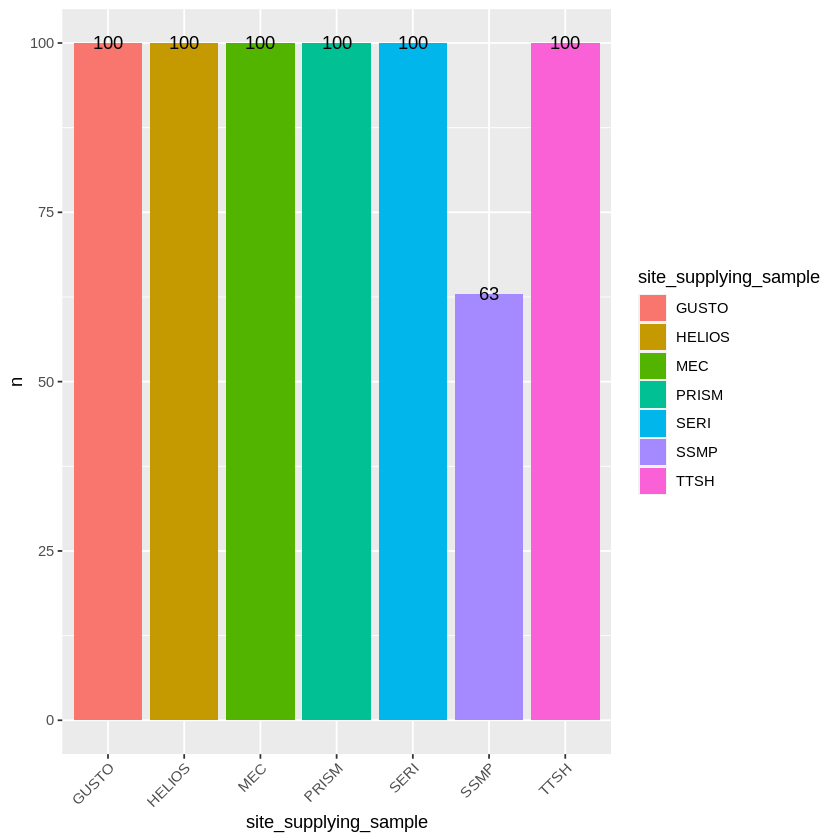

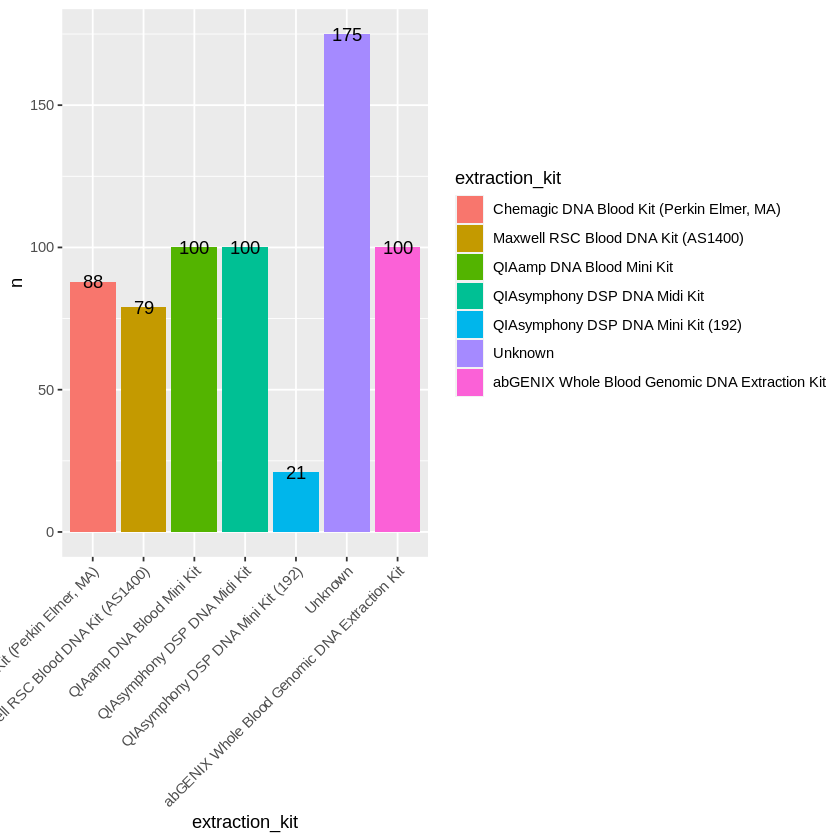

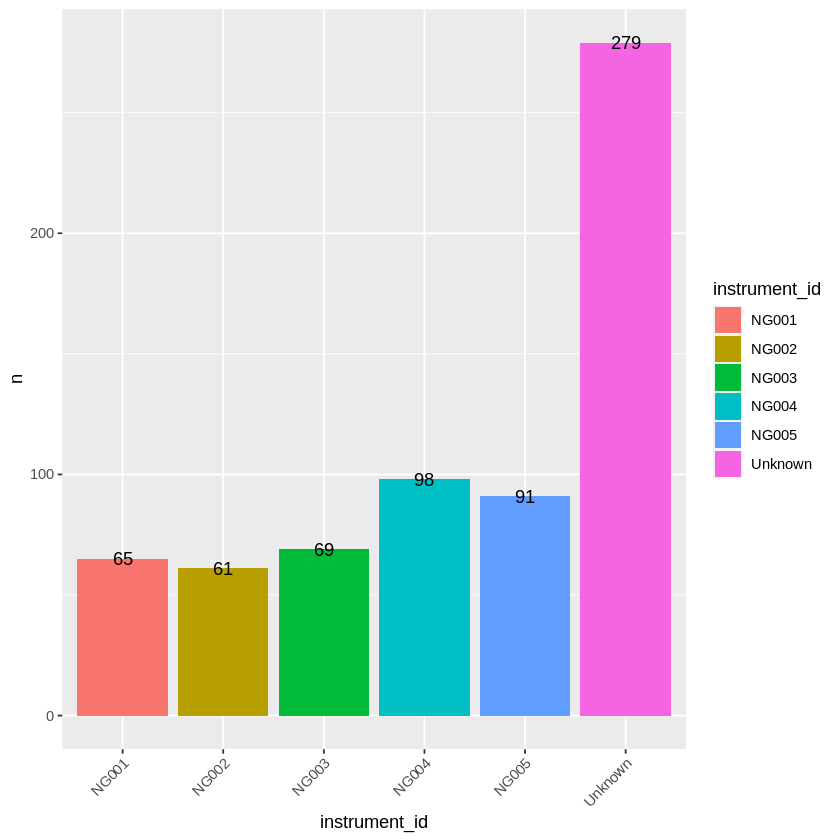

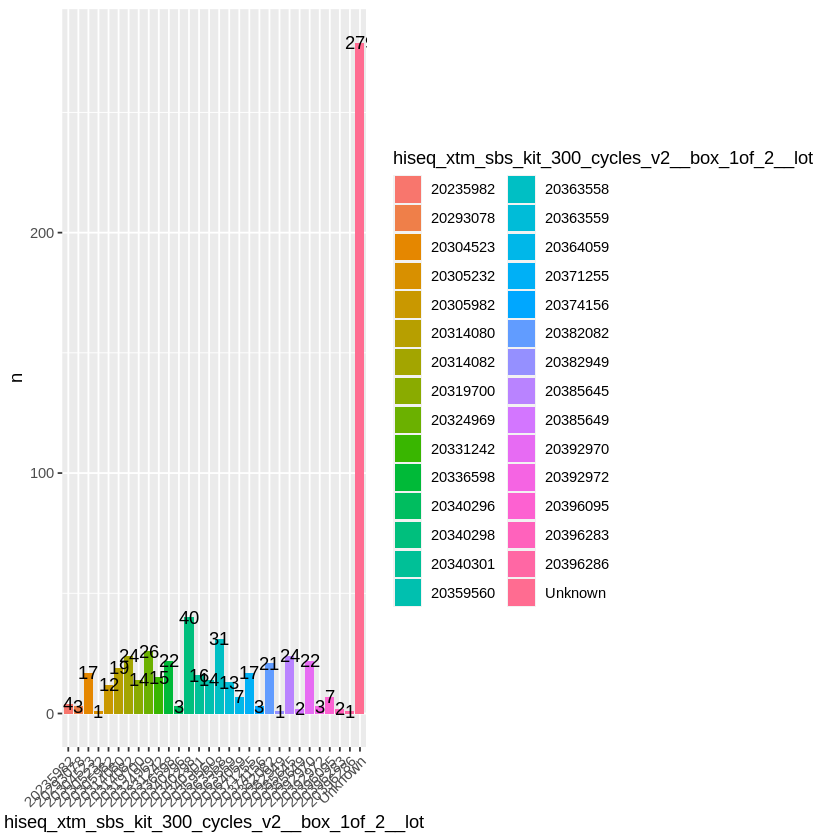

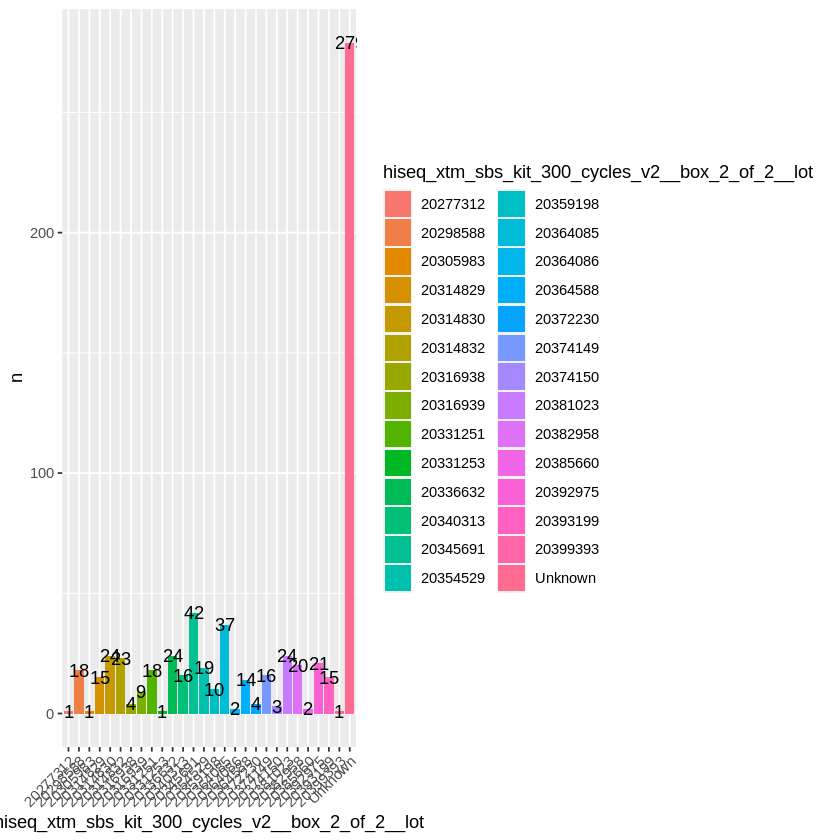

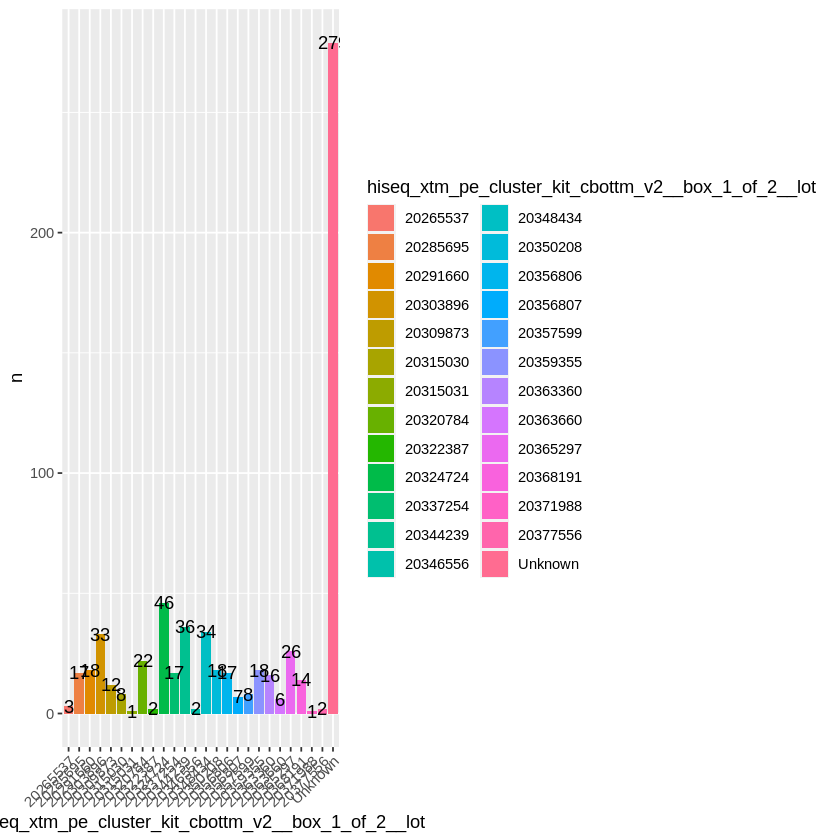

$site_supplying_sample

$extraction_kit

$instrument_id

$hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot

$hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot

$hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot

$hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot

$hiseq_xtm_flow_cell_v2_5_lot


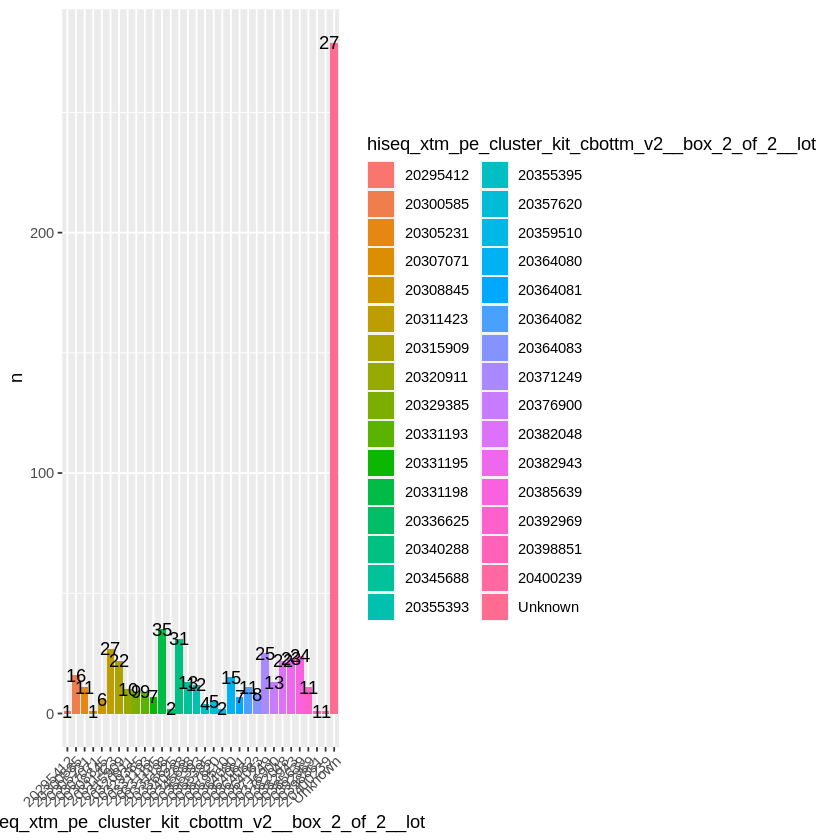

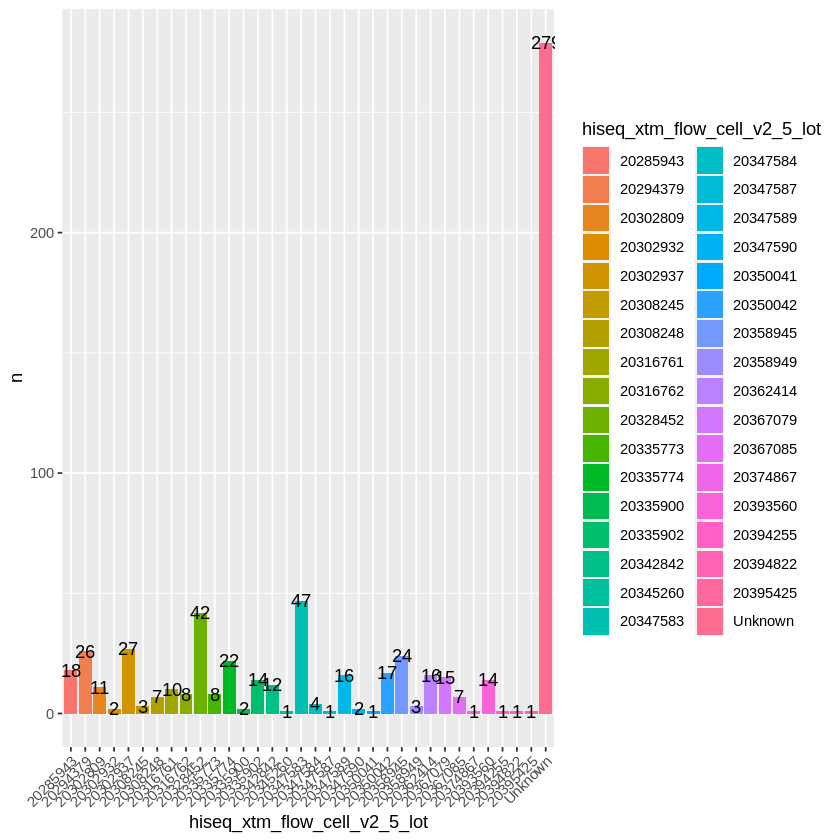

In [23]:
n_subset <- 100

# Load data
species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.S.tsv"))

# Retain relevant metadata
meta <- parse_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", species_df)

# Get metadata columns of interest
meta_cols <- get_meta_cols(meta)

meta <- as.matrix(meta)
meta <- as_tibble(meta, rownames = "sample")

plots <- list()

for (column in meta_cols) {
    plt <- meta %>%
        mutate(across(everything(), as.character)) %>%
        select(all_of(column)) %>%
        group_by_at(column) %>%
        summarise(n = n()) %>%
        ggplot(aes_string(x = column, y = "n", fill = column)) +
            geom_bar(stat = "identity") +
            theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
            geom_text(aes_string(label = "n"))
    plots[[column]] <- plt
}

plots


### MAIN

In [24]:
# nc_list <- list()

# for (i in c(100)) {
#     nc_list[[str_glue("subset_{i}")]] <- decontaminate(i)
# }

# nc_list

### Sanity check

In [25]:
# Reduce(intersect, nc_list)

ERROR: Error in Reduce(intersect, nc_list): object 'nc_list' not found


In [26]:
plot_sanity_plot <- function(X, Y, tax) {
    print(tax)
    temp_plt <- cbind(X, Y) %>%
        mutate(log_abundance = log(get(tax) + 0.0001)) %>%
        ggplot(aes(x = site_supplying_sample, y = get(tax), fill = site_supplying_sample)) + 
        geom_point() +
        geom_boxplot(alpha = 0.5) +
        labs(x = "Source cohort", y = paste(tax, "% abundance")) +
        theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1),
          text = element_text(size = 15))
    return(temp_plt)
}

[1] "Cutibacterium acnes"
Max no. of reads = 508
Mean no. of reads = 8.19457013574661


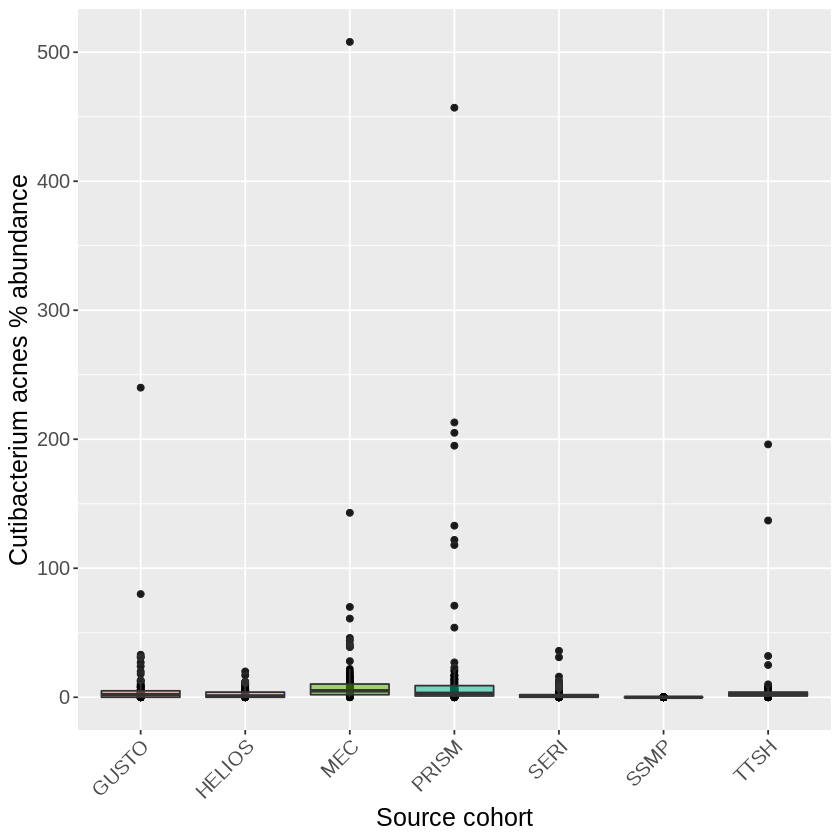

In [27]:
# Load data
taxon <- "Cutibacterium acnes"
species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.S.tsv"))

# Remove homo and unclassified
col_to_exclude <- colnames(species_df)[grepl("Homo|unclassified", colnames(species_df))]
species_df <- remove_cols(species_df, col_to_exclude)

# Retain relevant metadata
meta <- parse_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", species_df)

# Normalise to RA
normalise <- function(df) {
    RA_df <- t(apply(df, 1, function(x) {x / sum(x) * 100}))
    return(as_tibble(RA_df))
}

species_df_RA <- normalise(species_df)

plot_sanity_plot(species_df, meta, taxon)
print(str_glue("Max no. of reads = {max(species_df[, taxon])}"))
print(str_glue("Mean no. of reads = {mean(species_df[, taxon])}"))

In [33]:
l1 <- tibble(l1)

fwrite(l1, str_glue("/home/projects/14001280/PROJECTS/blood_microbiome/results/decontamination/decontaminated_list.n{n_subset}.csv"))

l1
<dbl>
1
2
3
